author: Diogo Silva

The commentaries made on this notebook were made before the correction of the accuracy algorithm. The accuracies before this correction were significantly worse.

In [1]:
%pylab inline
#%qtconsole

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import sklearn
from sklearn import preprocessing,decomposition,datasets

In [3]:
%cd /home/chiroptera/workspace/QCThesis/
import haddock.cluster.Horn as HornAlg
reload(HornAlg)

/home/chiroptera/workspace/QCThesis/Horn


<module 'HornAlg' from 'HornAlg.pyc'>

In [4]:
%cd /home/chiroptera/workspace/QCThesis/cluster\ consistency
import determine_ci
reload(determine_ci)

/home/chiroptera/workspace/QCThesis/cluster consistency


<module 'determine_ci' from 'determine_ci.pyc'>

In [3]:
# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [6]:
def save_subfig(filename,subfig,format="eps",dpi=500):
    fig=subfig.get_figure()
    allformats=list()
    
    if type(format) == str:
        allformats.append(format)
    elif type(format) == list:
        allformats=format
    else:
        raise Exception("incorrect format type")

    for f in allformats:
        
        # Save just the portion _inside_ the second axis's boundaries
        extent = subfig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

        # Pad the saved area by 10% in the x-direction and 20% in the y-direction
        fig.savefig(filename+"."+f, bbox_inches=extent.expanded(1.2, 1.25),format=f, dpi=dpi)
    
def save_fig(filename,fig=None,format="eps",dpi=500):
    allformats=list()
    
    if type(format) == str:
        allformats.append(format)
    elif type(format) == list:
        allformats=format
    else:
        raise Exception("incorrect format type")

    for f in allformats:
        if fig != None:
            fig.savefig(filename+"."+f, format=f, dpi=dpi)
        else:
            plt.savefig(filename+"."+f, format=f, dpi=dpi)

# Quantum Clustering with Schrödinger's equation

## Background

This method starts off by creating a Parzen-window density estimation of the input data by associating a Gaussian with each point, such that

$$ \psi (\mathbf{x}) = \sum ^N _{i=1} e^{- \frac{\left \| \mathbf{x}-\mathbf{x}_i \right \| ^2}{2 \sigma ^2}} $$

where $N$ is the total number of points in the dataset, $\sigma$ is the variance and $\psi$ is the probability density estimation. $\psi$ is chosen to be the wave function in Schrödinger's equation. The details of why this is are better described in [1-4]. Schrödinger's equation is solved in order of the potential function $V(x)$, whose minima will be the centers of the clusters of our data:

$$
V(\mathbf{x}) = E + \frac {\frac{\sigma^2}{2}\nabla^2 \psi }{\psi}
= E - \frac{d}{2} + \frac {1}{2 \sigma^2 \psi} \sum ^N _{i=1} \left \| \mathbf{x}-\mathbf{x}_i \right \| ^2 e^{- \frac{\left \| \mathbf{x}-\mathbf{x}_i \right \| ^2}{2 \sigma ^2}}
$$

And since the energy should be chosen such that $\psi$ is the groundstate (i.e. eigenstate corresponding to minimum eigenvalue) of the Hamiltonian operator associated with Schrödinger's equation (not represented above), the following is true

$$
E = - min \frac {\frac{\sigma^2}{2}\nabla^2 \psi }{\psi}
$$

With all of this, $V(x)$ can be computed. However, it's very computationally intensive to compute V(x) to the whole space, so we only compute the value of this function close to the datapoints. This should not be problematic since clusters' centers are generally close to the datapoints themselves. Even so, the minima may not lie on the datapoints themselves, so what we do is compute the potential at all datapoints and then apply the gradient descent method to move them to regions in space with lower potential.

There is another method to evolve the system other then by gradient descent which is explained in [4] and complements this on the Dynamic Quantum Clustering algorithm.

The code for this algorithm is available in Matlab in one of the authur's webpage ([David Horn](http://horn.tau.ac.il/QC.htm)). That code has been ported to Python and the version used in this notebook can be found [here](https://github.com/Chiroptera/QCThesis/blob/95020790d605cff1791810893439d419e16962d6/Horn/HornAlg.py).

## References

[1] D. Horn and A. Gottlieb, “The Method of Quantum Clustering.,” NIPS, no. 1, 2001.

[2] D. Horn, T. Aviv, A. Gottlieb, H. HaSharon, I. Axel, and R. Gan, “Method and Apparatus for Quantum Clustring,” 2010.

[3] D. Horn and A. Gottlieb, “Algorithm for Data Clustering in Pattern Recognition Problems Based on Quantum Mechanics,” Phys. Rev. Lett., vol. 88, no. 1, pp. 1–4, 2001.

[4] M. Weinstein and D. Horn, “Dynamic quantum clustering: a method for visual exploration of structures in data,” pp. 1–15.

In [7]:
def fineCluster2(xyData,pV,minD):
	
	n = xyData.shape[0]
	clust = np.zeros(n)
    
	# index of points sorted by potential
	sortedUnclust=pV.argsort()

	# index of unclestered point with lowest potential
	i=sortedUnclust[0]

	# fist cluster index is 1
	clustInd=1

	while np.min(clust)==0:
		x=xyData[i]

		# euclidean distance form 1 point to others
		D = np.sum((x-xyData)**2,axis=1)
		D = D**0.5

		clust = np.where(D<minD,clustInd,clust)
		
		# index of non clustered points
		# unclust=[x for x in clust if x == 0]
		clusted= clust.nonzero()[0]

		# sorted index of non clustered points
		sortedUnclust=[x for x in sortedUnclust if x not in clusted]

		if len(sortedUnclust) == 0:
			break

		#index of unclestered point with lowest potential
		i=sortedUnclust[0]

		clustInd += 1

	return clust

# Iris

The iris dataset ([available at the UCI ML repository](http://archive.ics.uci.edu/ml/datasets/Iris)) has 3 classes each with 50 datapoints each. There are 4 features. The data is preprocessed using PCA.

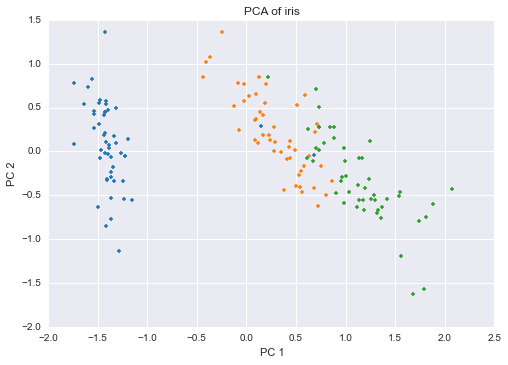

In [8]:
# load data
#dataset='/home/chiroptera/workspace/datasets/iris/iris.csv'
dataset='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
irisPCA=True
normalize=False

irisData=np.genfromtxt(dataset,delimiter=',')
irisData_o=irisData[:,:-1] # remove classification column

iN,iDims=irisData_o.shape

# PCA of data
if irisPCA:
    irisData_c,iComps,iEigs=HornAlg.pcaFun(irisData_o,whiten=True,center=True,method='eig',type='corr',normalize=normalize)
    
#print irisData, nirisData
#iris true assignment
irisAssign=np.ones(150)
irisAssign[50:99]=2
irisAssign[100:149]=3

#nirisData=sklearn.preprocessing.normalize(nirisData,axis=0)

iFig1=plt.figure()
plt.title('PCA of iris')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
for i in range(150):
    plt.plot(irisData_c[i,0],irisData_c[i,1],marker='.',c=tableau20[int(irisAssign[i]-1)*2])

In [9]:
print 'Energy of PC (in percentage):'
print np.cumsum(iEigs)*100/np.sum(iEigs)

Energy of PC (in percentage):
[  72.77045209   95.80097536   99.48480732  100.        ]


I choose $\sigma=\frac{1}{4}$ to reproduce the experiments in [3]. We use only the first two PC here. For more complete results the algorithm is also executed using all PC.

In [10]:
#%%timeit
sigma=0.25
steps=80

irisD1,iV1,iE=HornAlg.graddesc(irisData_c[:,0:2],sigma=sigma,steps=steps)

In [11]:
#%%timeit
sigma=0.9
steps=80

irisD2,iV2,iE=HornAlg.graddesc(irisData_c,sigma=sigma,steps=steps)

## Comments

The results shown above distinguish cluster assignment by colour. However, the colours might not be consistent throughout all figures. They serve only as a visual way to see how similar clusters are. This is due to the cluster assignment algorithm being used. Two methods may be used and differ only in the order on which they pick points to cluster. They both pick a point from the clustered data and compute the distance of that point to all the other points. All the points to which the corresponding distance is below a certain threshold belong to the same cluster. This process is repeated until all points are clustered. In one method the point picked to compute the distance is the first unclustered one. In the other method, the point picked is the one unassigned point that has the lowest potential value. Both methods suffer from assigning clusters to outliers.

Before analysing the results, some general comments may be made about the algorithm. A big advantage of the algorithm is that is does not make assumptions about the data (number of clusters, shape of clusters, intra-cluster distribution, etc.). A big disadvantage is that it doesn't assign points to clusters, if operated in an efficient way, i.e. not computing potential value on all points but only on datapoints and the direction they take. This is because the algorithm will converge points toward potential minima (akin to cluster centers) but will not tell which are these centers, which is the reason that the assignment methods described above are needed.

## Results
### PC 1 & 2

Number of clusters: 3.0
Accuracy:	0.86
Errors:		21.0


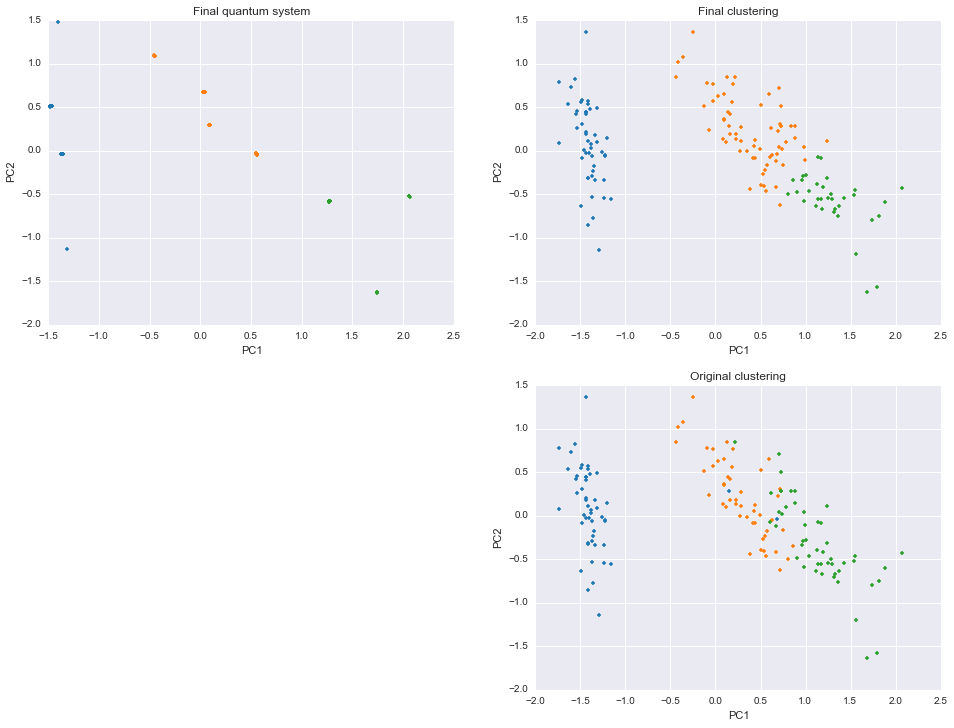

In [58]:
dist=1.8
irisClustering=HornAlg.fineCluster(irisD1,dist)#,potential=iV)

print 'Number of clusters:',max(irisClustering)

iFig2=plt.figure(figsize=(16,12))
iAx1=iFig2.add_subplot(2,2,1)
iAx2=iFig2.add_subplot(2,2,2)
iAx3=iFig2.add_subplot(2,2,4)

iAx1.set_title('Final quantum system')
iAx1.set_xlabel('PC1')
iAx1.set_ylabel('PC2')

for i in range(iN):
    if max(irisClustering) >=10:
        c=0
    else:
        c=int(irisClustering[i]-1)*2
    iAx1.plot(irisD1[i,0],irisD1[i,1],marker='.',c=tableau20[c])

iAx2.set_title('Final clustering')
iAx2.set_xlabel('PC1')
iAx2.set_ylabel('PC2')

for i in range(iN):
    if max(irisClustering) > 10:
        break
    iAx2.plot(irisData_c[i,0],irisData_c[i,1],marker='.',c=tableau20[int(irisClustering[i]-1)*2])

iAx3.set_title('Original clustering')
iAx3.set_xlabel('PC1')
iAx3.set_ylabel('PC2')

for i in range(iN):
    if max(irisClustering) > 10:
        break
    iAx3.plot(irisData_c[i,0],irisData_c[i,1],marker='.',c=tableau20[int(irisAssign[i]-1)*2])
    

irisCI=determine_ci.ConsistencyIndex(N=150)
irisAccuracy=irisCI.score(irisClustering,irisAssign,format='array')

print 'Accuracy:\t',irisAccuracy
print 'Errors:\t\t',irisCI.unmatch_count



Turning to the results, in the first case (clustering on the 2 first PC), the results show the clustering algorithm was able to cluster well one of the clusters (the one that is linearly seperable from the other two) but struggled with outliers present in the space of the other 2 clusters. Furthermore, the separation between the yellow and green clusters is hard, which not happens on the natural clusters. Observing the final quantum system, it's clear that all points converged to some minima as they are concentrated around some point and well seperated from other groups of points (other minima). If we were to take each minima as an independent cluster we would have 11 different clusters, which is considerably more than the natural 3. This means that some of the minima might represent micro clusters inside the natural clusters or outliers.

### All PC

Number of clusters: 3.0
Accuracy:	0.826666666667
Errors:		26.0


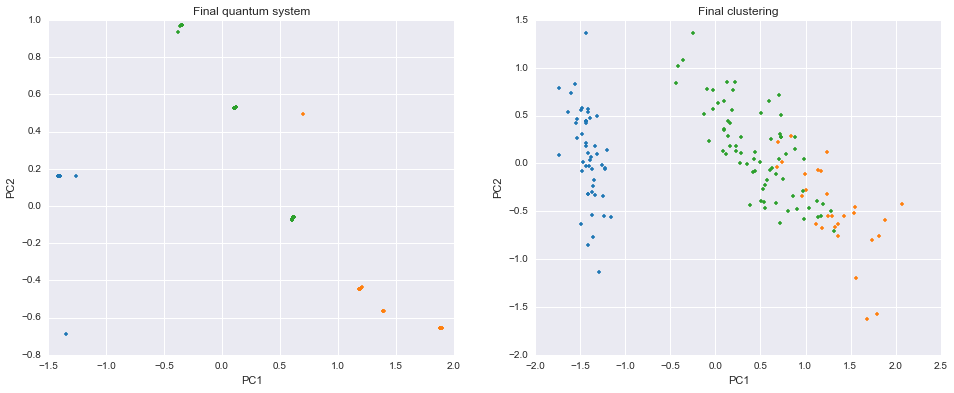

In [13]:
dist=4.5
irisClustering=HornAlg.fineCluster(irisD2,dist,potential=iV2)

print 'Number of clusters:',max(irisClustering)

iFig2=plt.figure(figsize=(16,6))
iAx1=iFig2.add_subplot(1,2,1)
iAx2=iFig2.add_subplot(1,2,2)
#iAx3=iFig2.add_subplot(2,2,4)

iAx1.set_title('Final quantum system')
iAx1.set_xlabel('PC1')
iAx1.set_ylabel('PC2')

for i in range(iN):
    if max(irisClustering) >=10:
        c=0
    else:
        c=int(irisClustering[i]-1)*2
    iAx1.plot(irisD2[i,0],irisD2[i,1],marker='.',c=tableau20[c])

iAx2.set_title('Final clustering')
iAx2.set_xlabel('PC1')
iAx2.set_ylabel('PC2')

for i in range(iN):
    if max(irisClustering) > 10:
        break
    iAx2.plot(irisData_c[i,0],irisData_c[i,1],marker='.',c=tableau20[int(irisClustering[i]-1)*2])
"""
iAx3.set_title('Original clustering')
iAx3.set_xlabel('PC1')
iAx3.set_ylabel('PC2')

for i in range(iN):
    iAx3.plot(irisData_c[i,0],irisData_c[i,1],marker='.',c=tableau20[int(irisAssign[i]-1)*2])
"""
irisCI=determine_ci.ConsistencyIndex(N=150)
irisAccuracy=irisCI.score(irisClustering,irisAssign,format='array')

print 'Accuracy:\t',irisAccuracy
print 'Errors:\t\t',irisCI.unmatch_count

In this case, we use all PC. In the final quantum system, the number of minima is the same. However, some of the minima are very close to others and have less datapoints assigned which suggest that they might be local minima and should probably be annexed to the bigger minima close by. Once again the outliers were not correctly classified. In this case, though, there is no hard boundary between the green and yellow clusters. This is due to the fact that we're now clustering on all PC which bring a greater ammount of information to the problem (the 2 first PC only ammounted around 95% of the energy).

# Crab

## Preparing dataset

Here we're loading the crab dataset and preprocessing it.

In [14]:
crabsPCA=True
crabsNormalize=False

crabs=np.genfromtxt('/home/chiroptera/workspace/datasets/crabs/crabs.dat')
crabsData=crabs[1:,3:]

# PCA
if crabsPCA:
    ncrabsData1, cComps,cEigs=HornAlg.pcaFun(crabsData,whiten=True,center=False,
                                             method='eig',type='cov',normalize=crabsNormalize)
    ncrabsData2, cComps,cEigs=HornAlg.pcaFun(crabsData,whiten=True,center=True,
                                             method='eig',type='corr',normalize=crabsNormalize)
    ncrabsData3, cComps,cEigs=HornAlg.pcaFun(crabsData,whiten=True,center=True,
                                             method='eig',type='cov',normalize=crabsNormalize)

    # real assignment
crabsAssign=np.ones(200)
crabsAssign[50:99]=2
crabsAssign[100:149]=3
crabsAssign[150:199]=4

We're visualizing the data projected on the second and third principal components to replicate the results presented on [3]. They use PCA with the correlation matrix. Below we can see the data on different representations. The closest representation of the data is using the covariance matrix with uncentered data (unconventional practice). Using the correlation matrix we get similar representation to unprocessed data. Although nonconvenional, the uncentered data plot suggests that data is more seperated that with centered data, using the covariance matrix.

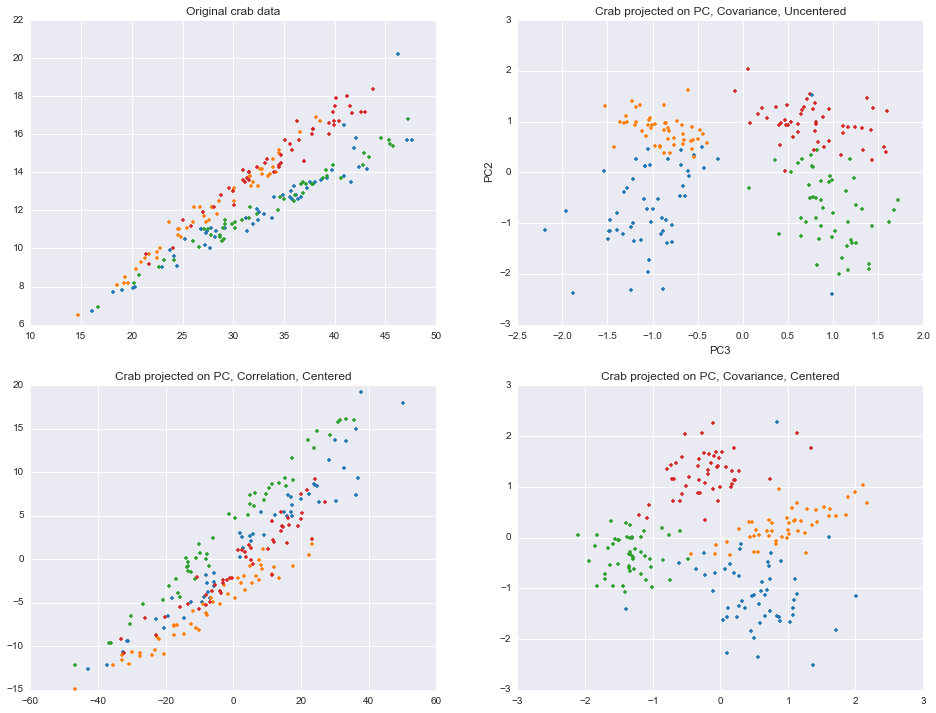

In [15]:
cFig1=plt.figure(figsize=(16,12))
cF1Ax1=cFig1.add_subplot(2,2,1)
cF1Ax2=cFig1.add_subplot(2,2,2)
cF1Ax3=cFig1.add_subplot(2,2,3)
cF1Ax4=cFig1.add_subplot(2,2,4)

cF1Ax1.set_title('Original crab data')
for i in range(len(crabsAssign)):
    cF1Ax1.plot(crabsData[i,2],crabsData[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])

cF1Ax2.set_title('Crab projected on PC, Covariance, Uncentered')
cF1Ax2.set_xlabel('PC3')
cF1Ax2.set_ylabel('PC2')
for i in range(len(crabsAssign)):
    cF1Ax2.plot(ncrabsData1[i,2],ncrabsData1[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])
    
cF1Ax3.set_title('Crab projected on PC, Correlation, Centered')
for i in range(len(crabsAssign)):
    cF1Ax3.plot(ncrabsData2[i,2],ncrabsData2[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])
    
cF1Ax4.set_title('Crab projected on PC, Covariance, Centered')
for i in range(len(crabsAssign)):
    cF1Ax4.plot(ncrabsData3[i,2],ncrabsData3[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])

## Cluster

We're clustering according to the second and third PC to try to replicate [3], along with the same $\sigma$.

In [79]:
#%%timeit

sigma=1.0/sqrt(2)
steps=80
crab2cluster=ncrabsData1
crabD,V,E=HornAlg.graddesc(crab2cluster[:,1:3],sigma=sigma,steps=steps)

Number of clusters: 4.0
Unclestered points: 0
Hungarian Accuracy:	0.815
CI Accuracy:	0.815


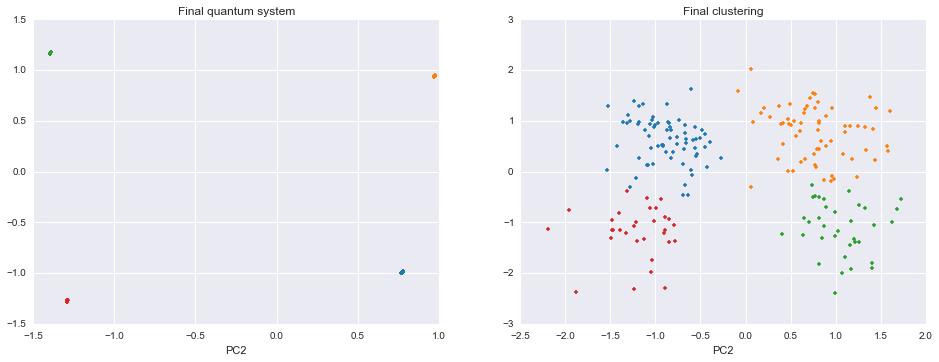

In [80]:

dist=1
crabClustering=HornAlg.fineCluster(crabD,dist,potential=V)

print 'Number of clusters:',max(crabClustering)
print 'Unclestered points:', np.count_nonzero(crabClustering==0)

cFig2=plt.figure(figsize=(16,12))
cAx1=cFig2.add_subplot(2,2,1)
cAx2=cFig2.add_subplot(2,2,2)
#cAx3=cFig2.add_subplot(2,2,4)
#cFig2,(cAx1,cAx2)=plt.subplots(nrows=1, ncols=2, )

cAx1.set_title('Final quantum system')
cAx1.set_xlabel("PC3")
cAx1.set_xlabel("PC2")
for i in range(len(crabsAssign)):
    if max(crabClustering) >= 10:
        c=0
    else:
        c=int(crabClustering[i]-1)*2
    cAx1.plot(crabD[i,0],crabD[i,1],marker='.',c=tableau20[c])

cAx2.set_title('Final clustering')
cAx2.set_xlabel("PC3")
cAx2.set_xlabel("PC2")
for i in range(len(crabsAssign)):
    if max(crabClustering) > 10:
        break
    cAx2.plot(crab2cluster[i,2],crab2cluster[i,1],marker='.',c=tableau20[int(crabClustering[i]-1)*2])
"""
cAx3.set_title('Original clustering')
cAx3.set_xlabel("PC3")
cAx3.set_xlabel("PC2")
for i in range(len(crabsAssign)):
    cAx3.plot(crab2cluster[i,2],crab2cluster[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])
"""
# Consistency index accuracy
crabCI=determine_ci.ConsistencyIndex(N=200)
crabAccuracy=crabCI.score(crabClustering,crabsAssign,format='array')

# Hungarian accuracy
hungAcc = determine_ci.HungarianAccuracy(nsamples=200)
hungAcc.score(crabClustering,crabsAssign,format='array')
print 'Hungarian Accuracy:\t',hungAcc.accuracy

print 'CI Accuracy:\t',crabAccuracy

In [18]:
crabCI.clusts1_.shape

(4, 200)

The 'Final quantum system' shows how the points evolved in 80 steps. We can see that they all converged to 4 minima of the potential for $\sigma=\frac{1}{\sqrt{2}}$, making it easy to identify the number of clusters to choose. However, this is only clear observing the results. The distance used to actually assign the points to the clusters need tampering with a per problem basis. We can see that outliers usually were incorrectly clustered. Plus, a considerable portion of data was also wrongly clustered. The accuracy of the clustering was the following:

## Conventional PCA

Now we'll cluster with the conventional PCA, with centered data.

In [77]:
sigma=1.0/sqrt(2)
steps=80
crab2cluster=ncrabsData3
crabD,V,E=HornAlg.graddesc(crab2cluster[:,1:3],sigma=sigma,steps=steps)

Number of clusters: 4.0
Unclestered points: 0
consistency index: 0.91
Hungarian Accuracy:	0.91


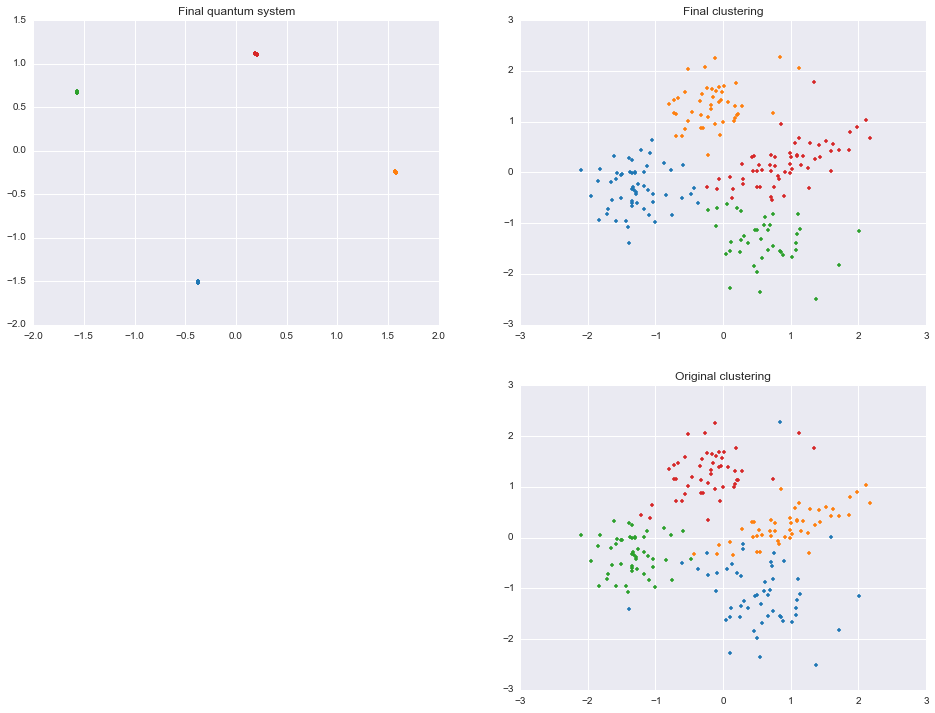

In [78]:
#%%debug
dist=1
crabClustering=HornAlg.fineCluster(crabD,dist,potential=V)

print 'Number of clusters:',max(crabClustering)
print 'Unclestered points:', np.count_nonzero(crabClustering==0)

cFig2=plt.figure(figsize=(16,12))
cAx1=cFig2.add_subplot(2,2,1)
cAx2=cFig2.add_subplot(2,2,2)
cAx3=cFig2.add_subplot(2,2,4)
#cFig2,(cAx1,cAx2)=plt.subplots(nrows=1, ncols=2, )

cAx1.set_title('Final quantum system')
for i in range(len(crabsAssign)):
    if max(crabClustering) >= 10:
        c=0
    else:
        c=int(crabClustering[i]-1)*2
    cAx1.plot(crabD[i,0],crabD[i,1],marker='.',c=tableau20[c])

cAx2.set_title('Final clustering')
for i in range(len(crabsAssign)):
    if max(crabClustering) > 10:
        break
    cAx2.plot(crab2cluster[i,2],crab2cluster[i,1],marker='.',c=tableau20[int(crabClustering[i]-1)*2])
    
cAx3.set_title('Original clustering')
for i in range(len(crabsAssign)):
    cAx3.plot(crab2cluster[i,2],crab2cluster[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])
    
crabCI=determine_ci.ConsistencyIndex(N=200)
crabAccuracy=crabCI.score(crabClustering,crabsAssign,format='array')
print "consistency index: {}".format(crabAccuracy)

# Hungarian accuracy
hungAcc = determine_ci.HungarianAccuracy(nsamples=200)
hungAcc.score(crabClustering,crabsAssign,format='array')
print 'Hungarian Accuracy:\t',hungAcc.accuracy

Using conventional PCA, clustering results are better.

## Other preprocessing
Let's now consider clustering on data projected on all principal components (with centered data) and on original data.

In [21]:
#1.0/np.sqrt(2)
sigma_allpc=0.5
steps_allpc=200
crabD_allpc,V_allpc,E=HornAlg.graddesc(ncrabsData1[:,:3],sigma=sigma_allpc,steps=steps_allpc)

In [22]:
sigma_origin=1.0/sqrt(2)
steps_origin=80
crabD_origin,V_origin,E=HornAlg.graddesc(crabsData,sigma=sigma_origin,steps=steps_origin)

All PC		Number of clusters: 4.0
All PC		Unclestered points: 0
All PC		Consistency index: 0.63
All PC		Hungarian Accuracy: 0.63
Original data	Number of clusters: 4.0
Original data	Unclestered points: 0
Original data	Consistency index: 0.34
Original data		Hungarian Accuracy: 0.34


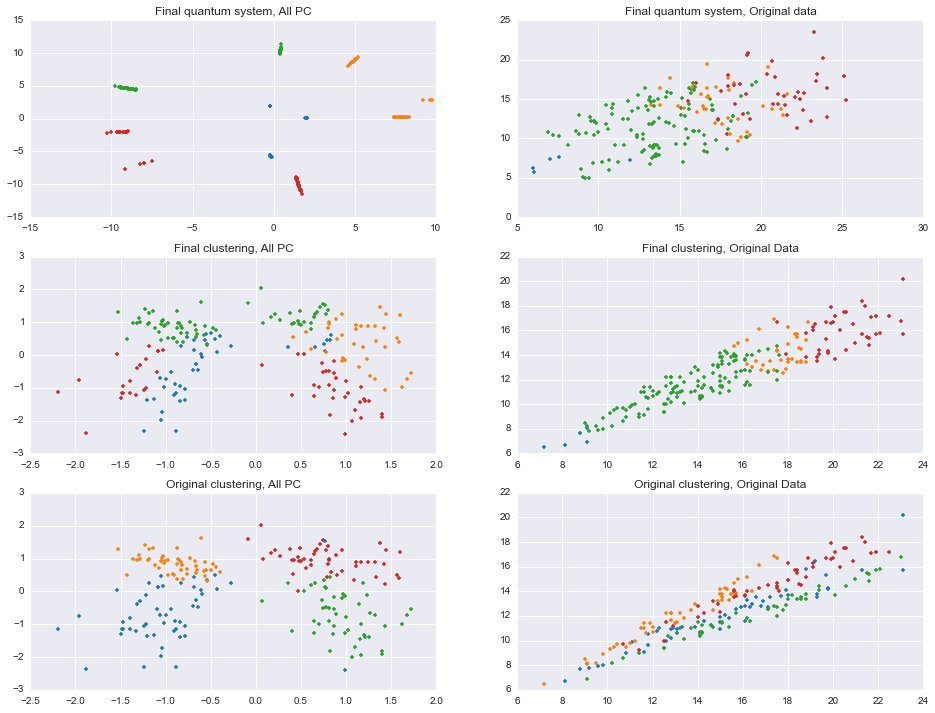

In [76]:
dist_allpc=12
dist_origin=15

crabClustering_allpc=HornAlg.fineCluster(crabD_allpc,dist_allpc,potential=V_allpc)
crabClustering_origin=HornAlg.fineCluster(crabD_origin,dist_origin,potential=V_origin)

crabCI=determine_ci.ConsistencyIndex(N=200)
crabAccuracy=crabCI.score(crabClustering_allpc,crabsAssign,format='array')

# Hungarian accuracy
hungAcc = determine_ci.HungarianAccuracy(nsamples=200)
hungAcc.score(crabClustering_allpc,crabsAssign,format='array')
crabHA = hungAcc.accuracy

crabCI2=determine_ci.ConsistencyIndex(N=200)
crabAccuracy2=crabCI2.score(crabClustering_origin,crabsAssign,format='array')

# Hungarian accuracy
hungAcc = determine_ci.HungarianAccuracy(nsamples=200)
hungAcc.score(crabClustering_origin,crabsAssign,format='array')
crabHA2 = hungAcc.accuracy

print 'All PC\t\tNumber of clusters:',max(crabClustering_allpc)
print 'All PC\t\tUnclestered points:', np.count_nonzero(crabClustering_allpc==0)
print 'All PC\t\tConsistency index:',crabAccuracy
print 'All PC\t\tHungarian Accuracy:',crabHA
print 'Original data\tNumber of clusters:',max(crabClustering_origin)
print 'Original data\tUnclestered points:', np.count_nonzero(crabClustering_origin==0)
print 'Original data\tConsistency index:',crabAccuracy2
print 'Original data\t\tHungarian Accuracy:',crabHA2

cFig2=plt.figure(figsize=(16,12))
cAx1=cFig2.add_subplot(3,2,1)
cAx2=cFig2.add_subplot(3,2,3)
cAx3=cFig2.add_subplot(3,2,5)

cAx4=cFig2.add_subplot(3,2,2)
cAx5=cFig2.add_subplot(3,2,4)
cAx6=cFig2.add_subplot(3,2,6)

cAx1.set_title('Final quantum system, All PC')
for i in range(len(crabsAssign)):
    if max(crabClustering_allpc) >= 10:
        c=0
    else:
        c=int(crabClustering_allpc[i]-1)*2
    cAx1.plot(crabD_allpc[i,2],crabD_allpc[i,1],marker='.',c=tableau20[c])

cAx2.set_title('Final clustering, All PC')
for i in range(len(crabsAssign)):
    if max(crabClustering_allpc) > 10:
        break
    cAx2.plot(ncrabsData1[i,2],ncrabsData1[i,1],marker='.',c=tableau20[int(crabClustering_allpc[i]-1)*2])
    
cAx3.set_title('Original clustering, All PC')
for i in range(len(crabsAssign)):
    cAx3.plot(ncrabsData1[i,2],ncrabsData1[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])

    #--------------------------------------------------------------#
    
cAx4.set_title('Final quantum system, Original data')
for i in range(len(crabsAssign)):
    if max(crabClustering_origin) >= 10:
        c=0
    else:
        c=int(crabClustering_origin[i]-1)*2
    cAx4.plot(crabD_origin[i,0],crabD_origin[i,1],marker='.',c=tableau20[c])

cAx5.set_title('Final clustering, Original Data')
for i in range(len(crabsAssign)):
    if max(crabClustering_origin) > 10:
        break
    cAx5.plot(crabsData[i,0],crabsData[i,1],marker='.',c=tableau20[int(crabClustering_origin[i]-1)*2])
    
cAx6.set_title('Original clustering, Original Data')
for i in range(len(crabsAssign)):
    cAx6.plot(crabsData[i,0],crabsData[i,1],marker='.',c=tableau20[int(crabsAssign[i]-1)*2])

The results of the last experimens show considerably worse results. The final quantum system suggests a great ammount of minima and bigger variance on the final convergence of the points. Furthermore the distribution of the minima doesn't suggest any natural clustering for the user, contrary to what happened before.

The clustering on raw data is very bad. This was to be expected considering the distribution and shape of the original data across all dimensions and clusters.

# Gaussian blobs

## Original Mix

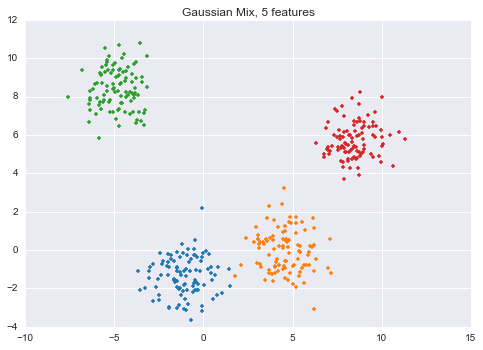

In [24]:
n_samples=400
n_features=5
centers=4

x_Gauss,x_assign=sklearn.datasets.make_blobs(n_samples=n_samples,n_features=n_features,centers=centers)
#nX=sklearn.preprocessing.normalize(x_Gauss,axis=0)
x_2cluster=x_Gauss

gMix_fig=plt.figure()
plt.title('Gaussian Mix, '+str(n_features)+' features')
for i in range(x_Gauss.shape[0]):
    plt.plot(x_2cluster[i,0],x_2cluster[i,1],marker='.',c=tableau20[int(x_assign[i])*2])

In [25]:
sigma=2.
steps=200
gaussD,V,E=HornAlg.graddesc(x_2cluster,sigma=sigma,steps=steps)

number of clusters= 104.0


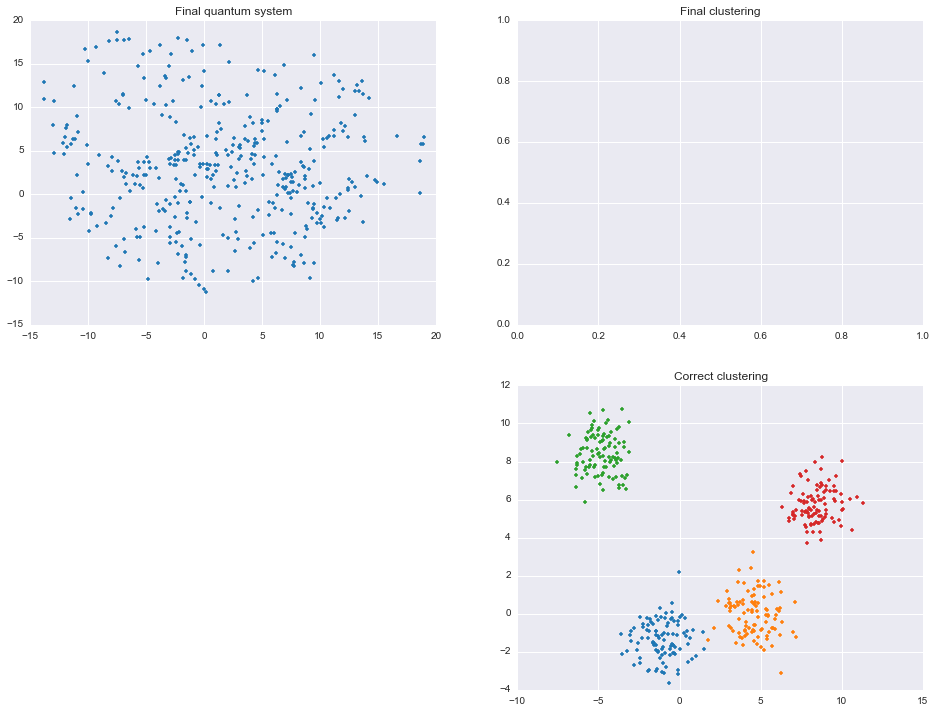

In [26]:
dist=6
nX_clustering=HornAlg.fineCluster(gaussD,dist,potential=V)
print 'number of clusters=',max(nX_clustering)

gRes_fig=plt.figure(figsize=(16,12))
gRes_ax1=gRes_fig.add_subplot(2,2,1)
gRes_ax2=gRes_fig.add_subplot(2,2,2)
gRes_ax3=gRes_fig.add_subplot(2,2,4)


gRes_ax1.set_title('Final quantum system')
for i in range(x_Gauss.shape[0]):
    if max(nX_clustering) > 10:
        c=0
    else:
        c=int(nX_clustering[i]-1)*2
    gRes_ax1.plot(gaussD[i,0],gaussD[i,1],marker='.',c=tableau20[c])

gRes_ax2.set_title('Final clustering')
for i in range(len(nX_clustering)):
    if max(nX_clustering) >10 :
        break
    gRes_ax2.plot(x_2cluster[i,0],x_2cluster[i,1],marker='.',c=tableau20[int(nX_clustering[i]-1)*2])
    
gRes_ax3.set_title('Correct clustering')
for i in range(x_Gauss.shape[0]):
    gRes_ax3.plot(x_2cluster[i,0],x_2cluster[i,1],marker='.',c=tableau20[int(x_assign[i])*2])

## PCA Mix

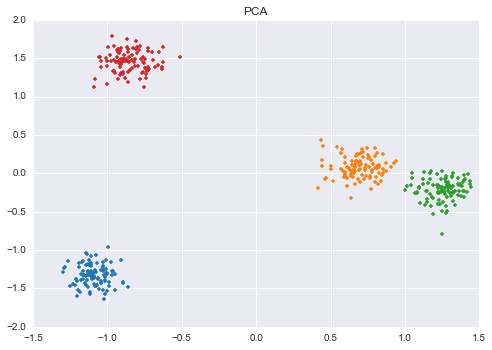

In [27]:
pcaX,gaussComps,gaussEigs=HornAlg.pcaFun(x_Gauss,whiten=True,center=True,
                                             method='eig',type='cov',normalize=False)
gPCAf=plt.figure()
plt.title('PCA')
for i in range(x_Gauss.shape[0]):
    plt.plot(pcaX[i,0],pcaX[i,1],marker='.',c=tableau20[int(x_assign[i])*2])

In [28]:
sigma=2.
steps=400
pcaGaussD,V,E,eta=HornAlg.graddesc(pcaX,sigma=sigma,steps=steps,return_eta=True)

number of clusters= 3.0


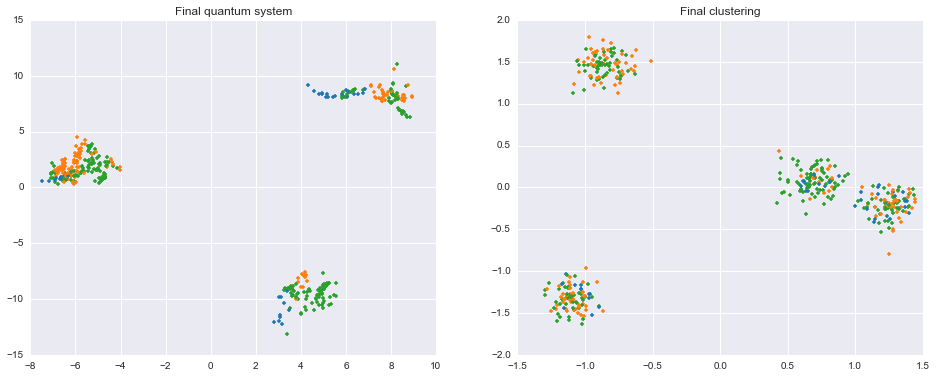

In [29]:
dist=28
pcaX_clustering=HornAlg.fineCluster(pcaGaussD,dist,potential=V)
print 'number of clusters=',max(pcaX_clustering)

gPCARes_fig,(gPCARes_ax1,gPCARes_ax2)=plt.subplots(nrows=1, ncols=2, figsize=(16,6))

gPCARes_ax1.set_title('Final quantum system')
for i in range(x_Gauss.shape[0]):
    if max(pcaX_clustering) > 10:
        c=0
    else:
        c=int(pcaX_clustering[i]-1)*2
    gPCARes_ax1.plot(pcaGaussD[i,0],pcaGaussD[i,2],marker='.',c=tableau20[c])

gPCARes_ax2.set_title('Final clustering')
for i in range(len(pcaX_clustering)):
    if max(pcaX_clustering) >10 :
        break
    gPCARes_ax2.plot(pcaX[i,0],pcaX[i,1],marker='.',c=tableau20[int(pcaX_clustering[i]-1)*2])

## Comments

The algorithm performed very poorly in unprocessed data. Even with a high $$\sigma$$ and big number of steps for the gradient descent, the final quantum system had points scattered all over, not even seemingly alike the original data, i.e. the points diverged. The performance on the projected data was significantly better. The final quantum system suggests some natural clustering to a user, assimilating 4 seperate clusters. However the assignment algorithm did a very poor job and the final clustering is all off. Paying close attention to the colours, though, we can see that the left most cluster only has two colours in both plots, which suggest a correspondence. The same can be done to the other clusters. A user using this algorithm would be able to do a better clustering in selecting which points should be together by analyzing the final quantum system plot. The assignment algorithm probably performs worse because of other dimensions. 